# Walmart Cost of Capital

# Setup

In [2]:
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import numpy_financial as npf
import random
from dataclasses import dataclass
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import xlwings as xw
from tkcalendar import DateEntry 

# Inputs

In [12]:
@dataclass
class ModelInputs:
    bond_years: int = 15
    bond_coupon: float = .0525
    bond_price: float = 130.58
    bond_par: float = 100
    risk_free: float = 0.005
    price: float = 119.51
    shares_outstanding: int = 2850000000
    libor_rate: float = 0.0196
    sp_500_file: str = 'SP500 Prices.xlsx'
    stock_prices_file: str = 'WMT Prices.xlsx'
    stock_ticker: str = 'WMT'
    balance_sheet_file: str = 'WMT Balance Sheet.xlsx'
    income_statement_file: str = 'WMT Income Statement.xlsx'
    mv_debt_details_file: str = 'WMT Debt Details.xls'
        
        
@dataclass
class SimulationInputs:
    num_iter: int = 10000
    beta_std: float = 0.2
    mkt_ret_std: float = 0.03
    bond_price_std: float = 30
    tax_rate_std: float = 0.05


model_data = ModelInputs()
sim_data = SimulationInputs()

# Load data once
@dataclass
class ExcelSheets:
    io_sht = xw.Book('Project 3.xlsx').sheets[0]
    sp500 = xw.Book(model_data.sp_500_file).sheets[0]
    wmt = xw.Book(model_data.stock_prices_file).sheets[0]
    income_stat = xw.Book(model_data.income_statement_file).sheets[0]
    balance_sheet = xw.Book(model_data.balance_sheet_file).sheets[0]
    debt_details = xw.Book(model_data.mv_debt_details_file).sheets[0]

excel_sheets = ExcelSheets()

# Model

In [18]:
# preprocess and precompute data
sp500_prices = excel_sheets.sp500.range('F1').expand('down').options(pd.DataFrame, index=0).value
wmt_prices = excel_sheets.wmt.range('F1').expand('down').options(pd.DataFrame, index=0).value
def read_debt_data(model_data, excel_sheets):  
    # Reading debt data from excel and putting it in a DataFrame
    df_debt = pd.DataFrame([(excel_sheets.debt_details.range(f'C{i}').value,
        excel_sheets.debt_details.range(f'D{i}').value,                
        excel_sheets.debt_details.range(f'F{i}').value)
        for i in range (14,76)],
        columns=[excel_sheets.debt_details.range('C13').value, excel_sheets.debt_details.range('D13').value, excel_sheets.debt_details.range('F13').value])
    
    # Cleaning the principal data
    for i in range(len(df_debt)):    
        principal = df_debt['Principal Due (USD)'][i]
        if isinstance(principal, str):
            df_debt.loc[i,'Principal Due (USD)'] = 0
        
    # cleaning coupon data (ranges)
    for i in range(len(df_debt)):
        coupon = df_debt['Coupon/Base Rate'][i]
        if isinstance(coupon, str) and '-' in coupon:
            parts = coupon.replace('%', '').split('-')
            midrange = ((float(parts[0]) + float(parts[1])) / 2) * 0.01
            df_debt.loc[i,'Coupon/Base Rate'] = midrange
        elif isinstance(coupon, str):
            df_debt.loc[i,'Coupon/Base Rate'] = 0
    
    # clean floating rate data. if it has a value, then add it to the base rate 
    floating_rates = [excel_sheets.debt_details.range(f'E{i}').value for i in range (14,76)]
    for i in range(len(floating_rates)):
        f_rate = floating_rates[i]
        if isinstance(f_rate, str) and '+' in f_rate:
            f_rate = float(f_rate.replace('%','').split('+')[1]) * 0.01
            coupon_rate = f_rate + model_data.libor_rate
            df_debt.loc[i, 'Coupon/Base Rate'] = coupon_rate    
    
    # cleaning the maturity data, turn it into num of years 
    statement_date = pd.to_datetime("2019-07-31")
    for i in range(len(df_debt)):
        if isinstance(df_debt['Maturity'][i], str):
            df_debt.loc[i,'Maturity'] = 0
            continue
        elif isinstance(df_debt['Maturity'][i], float):
            year = df_debt['Maturity'][i]
            date_format = pd.to_datetime(f"{int(year)}-12-31")
            df_debt.loc[i,'Maturity'] = date_format
        
        current_date = df_debt['Maturity'][i]
        delta = relativedelta(current_date, statement_date)
        difference = delta.years + delta.months / 12 + delta.days / 365.25
        df_debt.loc[i,'Maturity'] = difference
    
    return df_debt


def beta_regression(model_data, sp500_prices, wmt_prices):
    # Compute log returns for WMT and S&P 500
    returns_wmt = wmt_prices.pct_change().dropna() #np.log(wmt_prices / wmt_prices.shift(1))
    returns_sp500 = sp500_prices.pct_change().dropna() #np.log(sp500_prices / sp500_prices.shift(1))
    
    # Calculate daily risk-free rate
    daily_risk_free = model_data.risk_free / 252
    
    # Calculate excess returns
    sp500_excess_returns = returns_sp500 - daily_risk_free

    # Regress WMT excess returns on SP500 excess returns to get β
    X = sm.add_constant(sp500_excess_returns.dropna())
    model = sm.OLS(returns_wmt, X).fit()
    
    return model.params.iloc[1]

def market_return(sp500_prices):
    # Calculate arithmetic market return
    sp500_daily_returns = sp500_prices.pct_change().dropna()
    daily_returns = sp500_daily_returns.mean()
    annual_return = daily_returns * 252

    return annual_return.values[0]

def get_tax_rate(excel_sheets):
    earnings_before_tax = excel_sheets.income_stat.range('A11').expand('right').value[-1]
    income_tax_expense = excel_sheets.income_stat.range('A12').expand('right').value[-1]
    return income_tax_expense / earnings_before_tax


df_debt = read_debt_data(model_data, excel_sheets)
beta = beta_regression(model_data, sp500_prices, wmt_prices)
mkt_ret = market_return(sp500_prices) 
tax_rate = get_tax_rate(excel_sheets)

beta

0.6248324465315509

## Equity

In [19]:
def cost_of_equity(model_data, beta, mkt_ret):
    # Load and preprocess data
    risk_free = model_data.risk_free

    # Step 5: Apply CAPM formula
    coe = risk_free + beta * (mkt_ret - risk_free)
    
    return coe

# formula: MVE = Share Price × Shares Outstanding
def market_value_of_equity(model_data):
    mve = model_data.price * model_data.shares_outstanding
    return mve

result = cost_of_equity(model_data, beta, mkt_ret)
print(f'{result:.2%}')

5.96%


# Debt

In [64]:
def pretax_cost_of_debt(model_data):
    ytm = npf.rate(model_data.bond_years, model_data.bond_coupon*model_data.bond_par, -model_data.bond_price, model_data.bond_par)
    return ytm

ytm = pretax_cost_of_debt(model_data)

def bond_price_calc(par, coupon, ytm, maturity, freq=1):
    """Calculate bond price with annual coupons by default"""
    ytm = pretax_cost_of_debt(model_data)
    ytm_per = ytm / freq
    periods = maturity * freq
    coupon_pmt = (coupon * par) / freq
    
    price = 0
    for t in range(1, int(periods) + 1):
        # Discount coupon payments
        price += coupon_pmt / (1 + ytm_per)**t
    
    # Discount principal
    price += par / (1 + ytm_per)**periods
    return price

def market_value_of_debt(df_debt, model_data):
    df = df_debt
    mv_bonds = []
    # ytm of the walmart's bond
    ytm = pretax_cost_of_debt(model_data)

    for i in range(len(df)):
        par = df['Principal Due (USD)'][i]
        coupon_rate = df['Coupon/Base Rate'][i] 
        maturity = df['Maturity'][i] 

        # if we have par we skip it , if we have no data (maturity, coupon rate) we estimate par as the price
        if par == 0:
            continue
        elif coupon_rate == 0 or maturity == 0:
            mv_bonds.append(par)
            continue
        
        # calculate market value of bond
        price = bond_price_calc(par, coupon_rate, ytm, maturity, 2)  # $196.02M
        mv_bonds.append(price)
    
    # market value of debt (unit is millions usd)
    mvd = sum(mv_bonds) * 1000000

    # cost of debt
    return mvd

mv_debt = market_value_of_debt(df_debt, model_data)
print(f'this is the old model: {mv_debt:,.2f}')

mvd = df_debt['Value'].sum() 
print(f'this is the NEW model: {mvd:}')

df_debt

this is the old model: 82,729,137,535.11
this is the NEW model: 83515.55444082699


,Principal Due (USD),Coupon/Base Rate,Maturity,Value
0,619.0,0.00183,2.957734,588.634750
1,354.0,0.00298,4.965948,321.704541
2,530.0,0.0052,7.960472,456.065028
3,88.0,0.016,0.993326,87.026168
4,1198.0,0.0175,0.191307,1186.491731
...,...,...,...,...
57,42.0,0,0,40.881119
58,1243.0,0.0325,9.938569,1293.271910
59,1242.0,0.0305,6.938569,1263.249765
60,1493.0,0.0285,4.938569,1499.315488


## WACC

In [13]:
def wacc_formula(E, D, Re, Rd, Tc):
    """
    Calculate Weighted Average Cost of Capital (WACC).
    
    Parameters:
        E (float): Market value of equity
        D (float): Market value of debt
        Re (float): Cost of equity (decimal)
        Rd (float): Cost of debt (decimal)
        Tc (float): Corporate tax rate (decimal)
    
    Returns:
        float: WACC as a decimal
    """
    V = E + D
    return (E/V * Re) + (D/V * Rd * (1 - Tc))

# Monte Carlo Simulation

In [15]:
def positive_normalvariate(mean, std):
    drawn_value = -1
    while drawn_value < 0: 
        drawn_value = random.normalvariate(mean, std)
    return drawn_value

def wacc_single_simulation(model_data, sim_data, beta, mkt_ret, tax_rate):
    # normal distribution of beta 
    beta_mean = beta
    beta_std = sim_data.beta_std
    beta = positive_normalvariate(beta_mean, beta_std)

    # normal distribution of market return 
    mkt_ret_mean = mkt_ret
    mkt_ret_std = sim_data.mkt_ret_std
    mkt_ret = positive_normalvariate(mkt_ret_mean, mkt_ret_std)
    
    # normal distribution of bond price COST OF DEBT
    price_mean = model_data.bond_price
    price_std = sim_data.bond_price_std
    price = positive_normalvariate(price_mean, price_std)
    
    # normal distribution of tax rate DIRECTLY TO WACC
    tax_mean = tax_rate
    tax_std = sim_data.tax_rate_std
    tax = positive_normalvariate(tax_mean, tax_std)

    # run the wacc function
    coe = cost_of_equity(model_data, beta, mkt_ret) # changes with beta & market return
    cod = pretax_cost_of_debt(price, model_data) # changes with bond price (ytm)
    mve = market_value_of_equity(model_data) # doesn't change
    mvd = market_value_of_debt(df_debt, price, model_data) # changes with bond price (indirectly thru ytm)
    wacc = wacc_formula(mve, mvd, coe, cod, tax) # changes with all variables + tax rate 
    return (beta, mkt_ret, price, tax, wacc)

def wacc_mc_simulation(model_data, sim_data, beta, mkt_ret, tax_rate):
    results = [wacc_single_simulation(model_data, sim_data, beta, mkt_ret, tax_rate) for i in range(sim_data.num_iter)]
    df = pd.DataFrame(results, columns=['Beta', 'Market Return', 'Bond Price', 'Tax Rate', 'WACC'])

    return df

## Outputs

In [17]:
# Main answer for baseline case should be numbers (NOT formatted strings) stored into the following variables:
coe = cost_of_equity(model_data, beta, mkt_ret)
mv_equity = market_value_of_equity(model_data)
pretax_cod = pretax_cost_of_debt(model_data.bond_price, model_data)
aftertax_cod = pretax_cod * (1 - tax_rate)
mv_debt = market_value_of_debt(df_debt, model_data.bond_price, model_data)
tax_rate = tax_rate
wacc = wacc_formula(mv_equity, mv_debt, coe, pretax_cod, tax_rate)

# store the values into excel
excel_sheets.io_sht.range('B24').value = wacc
excel_sheets.io_sht.range('B27').value = coe
excel_sheets.io_sht.range('B28').value = mv_equity
excel_sheets.io_sht.range('B29').value = pretax_cod
excel_sheets.io_sht.range('B30').value = aftertax_cod
excel_sheets.io_sht.range('B31').value = mv_debt

# Main answer for Monte Carlo simulation should be a DataFrame with columns of ['Beta', 'Market Return', 'Bond Price', 'Tax Rate', 'WACC']
# Be sure to save this into wacc_mc_df
wacc_mc_df = wacc_mc_simulation(model_data, sim_data, beta, mkt_ret, tax_rate)
wacc_mc_df

,Beta,Market Return,Bond Price,Tax Rate,WACC
0,0.383166,0.072552,112.334495,0.225378,0.031088
1,0.438484,0.066393,133.563934,0.182908,0.029706
2,0.528727,0.093375,147.364405,0.238308,0.043689
3,0.355641,0.075639,91.120189,0.184354,0.033584
4,0.599442,0.077731,147.071723,0.375471,0.040766
...,...,...,...,...,...
9995,0.251709,0.089023,114.892979,0.229692,0.026899
9996,0.468581,0.078560,124.844601,0.235497,0.036511
9997,0.658669,0.091153,129.974446,0.267759,0.053672
9998,0.684280,0.143396,83.566455,0.350532,0.090755


# Data Analysis

## Visualization and Summary

In [20]:
def styled_df(df):
    return df.style.format({
        'Beta': '{:.2f}',
        'Market Return': '{:.2%}',
        'Bond Price': '${:.2f}',
        'Tax Rate': '{:.2%}',
        'WACC': '{:.2%}',
    })

styled_df(wacc_mc_df.head())

,Beta,Market Return,Bond Price,Tax Rate,WACC
0,0.38,7.26%,$112.33,22.54%,3.11%
1,0.44,6.64%,$133.56,18.29%,2.97%
2,0.53,9.34%,$147.36,23.83%,4.37%
3,0.36,7.56%,$91.12,18.44%,3.36%
4,0.60,7.77%,$147.07,37.55%,4.08%


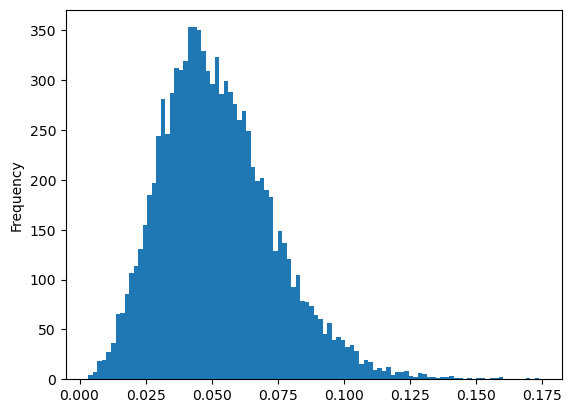

,Beta,Market Return,Bond Price,Tax Rate,WACC
5%,0.30,4.43%,$80.56,17.01%,2.14%
10%,0.37,5.44%,$91.72,18.84%,2.71%
15%,0.42,6.21%,$98.62,20.09%,3.09%
20%,0.45,6.77%,$104.80,21.08%,3.42%
25%,0.49,7.26%,$109.91,21.97%,3.69%
30%,0.52,7.69%,$114.41,22.78%,3.98%
35%,0.55,8.12%,$118.55,23.45%,4.22%
40%,0.57,8.52%,$122.68,24.12%,4.47%
45%,0.60,8.88%,$126.41,24.79%,4.73%
50%,0.62,9.26%,$130.27,25.42%,4.99%


In [21]:
def model_summary(df):
    display(HTML('<h3>Probability Distribution</h3>'))
    df['WACC'].plot.hist(bins=100);
    plt.show()
    
    prob_table = df.quantile([i/20 for i in range(1, 20)])
    styled_prob_table = styled_df(prob_table).format_index('{:.0%}')
    display(HTML('<h3>Probability Table</h3>'))
    display(styled_prob_table)
    print('')
    
    return

model_summary(wacc_mc_df)

## Relationship between Inputs and Outputs

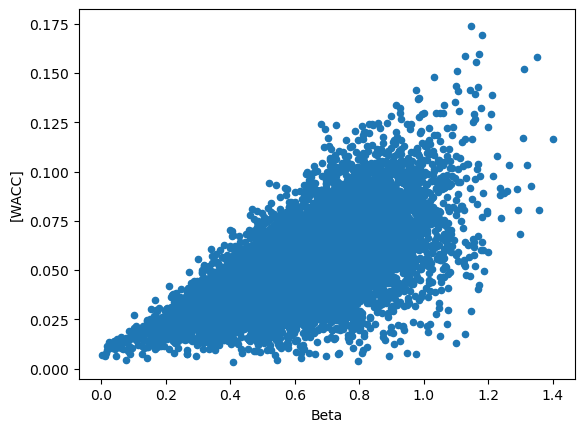

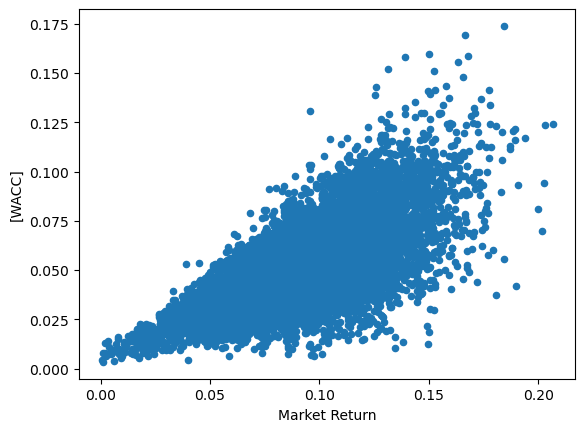

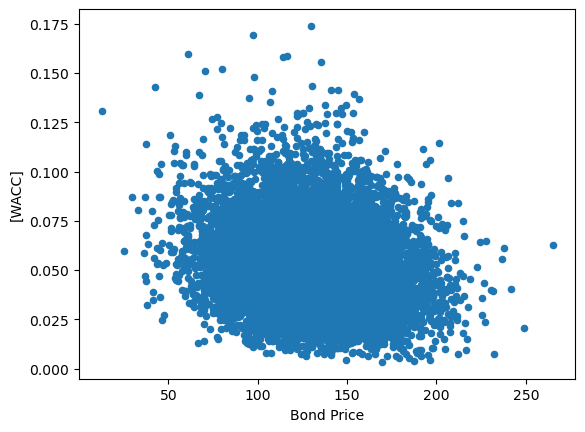

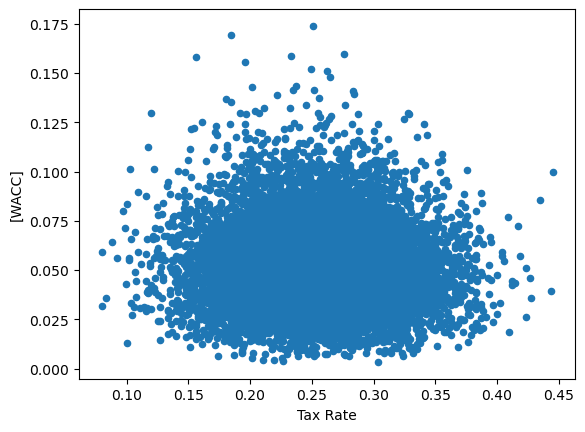

In [25]:
inputs = ['Beta',
          'Market Return',
          'Bond Price',
          'Tax Rate']
output = ['WACC']

for i in inputs:
    display(HTML(f'<h3>WACC vs {i}</h3>'))

    wacc_mc_df.plot.scatter(y=output, x=i); 
    plt.show()

In [31]:
# Multivariate Regression
X = sm.add_constant(wacc_mc_df[inputs])
y = wacc_mc_df[output]

mod = sm.OLS(y, X, hasconst=True)
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   WACC   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                 4.549e+04
Date:                Wed, 02 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:44:10   Log-Likelihood:                 39016.
No. Observations:               10000   AIC:                        -7.802e+04
Df Residuals:                    9995   BIC:                        -7.799e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0196      0.000    -49.423      0.000      -0.020      -0.019
Beta              0.0700      0.000    285.666      0.000       0.069       0.070
Market Return     0.5040      0.002    306.168      0.000       0.501       0.507
Bond Price       -0.0001   1.62e-06    -80.067      0.000      -0.000      -0.000
Tax Rate         -0.0060      0.001     -6.222      0.000      -0.008      -0.004
==============================================================================
Omnibus:                     1367.856   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16183.377
Skew:                           0.212   Prob(JB):                         0.00
Kurtosis:                       9.218   Cond. No.                     4.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
result.params * wacc_mc_df.std()

Beta             0.013973
Bond Price      -0.003917
Market Return    0.014978
Tax Rate        -0.000304
WACC                  NaN
const                 NaN
dtype: float64